In [2]:
import numpy as np
import pandas as pd
import subprocess as sp
import os
from tqdm import tqdm
from model_functions import *
# from rnaseq_tools import *
from matplotlib import pyplot as plt

In [20]:
import scipy as sc

In [22]:
sc.__version__

'1.4.1'

In [50]:
import numba_special

ImportError: scipy.special.cython_special does not export expected C function __pyx_fuse_0pdtr

In [31]:
def make_turbo(out_dir = 'psix_turbo/', granularity = 0.01, max_mrna = 20, capture_efficiency=0.1, min_probability=0.01):
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    observed_range = np.arange(0, 1+granularity, granularity)
    true_range = np.arange(granularity, 1, granularity)
    mrna_range = np.arange(1, max_mrna+1)
    
    for mrna in tqdm(mrna_range, leave=True, position=0):
        mrna_df = pd.DataFrame(np.ones((len(observed_range), len(true_range)))*min_probability, 
                               index=observed_range, columns=true_range)
        for observed_psi in observed_range:
            for true_psi in true_range:
                probability = probability_psi_observation(observed_psi, true_psi, capture_efficiency, mrna)
                mrna_df.loc[observed_psi, true_psi] = np.max((mrna_df.loc[observed_psi, true_psi], probability))

        mrna_df.to_csv(out_dir + 'psix_turbo_' + str(mrna)+'.tab.gz', sep='\t', index=True, header=True)

In [32]:
train_turbo()

100%|██████████| 20/20 [01:49<00:00,  5.46s/it]


In [1]:
def load_turbo(turbo_dir = 'psix_turbo/'):
#     turbo_files = os.listdir(turbo_dir)
    turbo_files = ['psix_turbo_'+str(i)+'.tab.gz' for i in range(1, 21)]
#     print(turbo_files)
    turbo_dict = []
    for x in tqdm(turbo_files, position=0, leave=True):
        mrna_counts = int(x.split('.')[0].split('_')[-1])
        turbo_table = np.array(pd.read_csv(turbo_dir + x, sep='\t', index_col=0))
        turbo_dict.append(turbo_table)
    return turbo_dict

In [3]:
turbo_dict = load_turbo()

100%|██████████| 20/20 [00:00<00:00, 59.33it/s]


In [10]:
turbo_dict[19].min()

0.01

In [25]:
def get_psi_10X(SJ_table_name, minJR=1, minCell=1, drop_duplicates = False):
    '''
    
    This functions splits this table into one individual for
    each junction type. It additionally creates a PSI table
    based on PSI = (I1 + I2) / ((I1 + I2) + 2*SE)
    
    Input:
    - SJ_counts_table is a pandas dataframe, with rows corresponding
      to individual splicing junctions, and columns corresponding to
      single cells.
    
      The format of the index is:
      Gene_X_SJ
      Where Gene correspond to the gene where the splicing event
      is present. X is a number assigned to one particulat ASE. 
      NMD events have additionally _nmdSE_ between Gene and X.
      SJ corresponds to I1 (included 1), I2 (included 2) or SE
      (skipped exon).
    
    - minCell (int) is the minimum number of cells that are required
      to have at least minJR reads.
    
    - minJR (int) determines the minimum number of reads required on
      at least minCell cells for a junction to be acceptable.
    
    Output:
    - I1_counts (DF) Counts for one Included SJ
    - I2_counts (DF) Counts for the other Included SJ 
    - SE_counts (DF) Counts for Skipped Exon SJ 
    - PSI_table (DF) As in name.
    - total_counts (DF) SE + (I1 + I2)
    
    '''
    
    if drop_duplicates:
        SJ_counts_table = pd.read_csv(SJ_table_name, sep='\t', index_col=0).drop_duplicates('last')
    else:
        SJ_counts_table = pd.read_csv(SJ_table_name, sep='\t', index_col=0)
    
    
    events = sorted(set([x[:-3] for x in SJ_counts_table.index]))
    
    i1_events = [x + '_I1' for x in events]
    I1_table = SJ_counts_table.loc[i1_events]
    I1_table.index = events
    
    i2_events = [x + '_I2' for x in events]
    I2_table = SJ_counts_table.loc[i2_events]
    I2_table.index = events
    
    se_events = [x + '_SE' for x in events]
    SE_table = SJ_counts_table.loc[se_events]
    SE_table.index = events
    
    I1_filt = I1_table.index[(I1_table > minJR).sum(axis=1) > minCell]
    I2_filt = I2_table.index[(I2_table > minJR).sum(axis=1) > minCell]
    SE_filt = SE_table.index[(SE_table > minJR).sum(axis=1) > minCell]
    
    filtered_events = I1_filt & I2_filt & SE_filt
    
    I1_table = I1_table.loc[filtered_events]
    I2_table = I2_table.loc[filtered_events]
    SE_table = SE_table.loc[filtered_events]
    
    I_table = pd.concat([I1_table, I2_table]).max(level=0)
    
    PSI_table = I_table /(SE_table + I_table)
    total_counts = SE_table + I2_table

    return PSI_table, total_counts

In [23]:
(pd.DataFrame(np.zeros((3, 3))), pd.DataFrame(np.ones((3, 3))))

(     0    1    2
 0  0.0  0.0  0.0
 1  0.0  0.0  0.0
 2  0.0  0.0  0.0,
      0    1    2
 0  1.0  1.0  1.0
 1  1.0  1.0  1.0
 2  1.0  1.0  1.0)

In [26]:
SE_counts = get_psi_10X(SJ_table_name, 
                          minJR=1, minCell=1, drop_duplicates = False)

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([148.,   0.,   0.,   2.,   0.,  17.,   1.,   0.,   0., 779.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

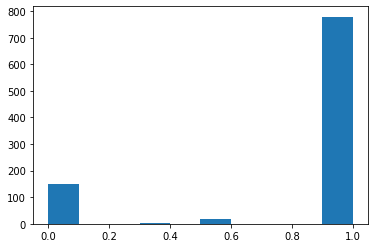

In [29]:
plt.hist(SE_counts[0].iloc[0])

(array([1.0384e+04, 0.0000e+00, 0.0000e+00, 5.0400e+02, 0.0000e+00,
        0.0000e+00, 1.2000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

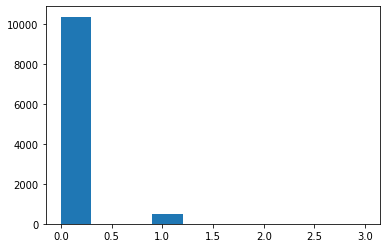

In [30]:
plt.hist(SE_counts[1].iloc[0])

(array([21.,  9.,  4.,  4.,  9.,  7., 13.,  7., 16., 18.]),
 array([0.        , 0.09990827, 0.19981655, 0.29972482, 0.39963309,
        0.49954137, 0.59944964, 0.69935792, 0.79926619, 0.89917446,
        0.99908274]),
 <a list of 10 Patch objects>)

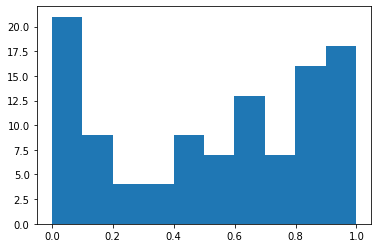

In [35]:
plt.hist(SE_counts[0].isna().mean(axis=1))

In [ ]:
def get_neighbors_turbo()

In [18]:
def compute_weight(d, sigma):
    return np.exp(-(d**2)/(sigma**2)) 


def compute_cell_metric_2(
    manifold, 
    n_neighbors=100, 
    weight_metric = True,
    remove_self = True
):
    
    
    cells = manifold.index
    n_cells = len(cells)
    
    knn_neighbors = NearestNeighbors(n_neighbors=n_neighbors+1).fit(manifold)
    distances, indices = knn_neighbors.kneighbors(manifold)
    
    
    
    neighbor_indices = pd.DataFrame(indices, index=cells)
    
    weights = np.ones((len(cells), (n_neighbors+1)))
    
    for i in tqdm(range(len(latent.index)), position=0, leave=True):
        sigma = np.max(distances[i])
        for j in range(1, len(distances[i])):
            d = distances[i][j]
            w = compute_weight(d, sigma)
            weights[i, j] = w
        
    cell_metric = (indices, weights)
    return cell_metric

In [19]:
latent = pd.read_csv('~/psix_project/analysis_psix/mouse_brain_development/data/preprocess/tables/pc2_rd.tab.gz', 
                     sep='\t', index_col=0)

In [20]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm 

knn_neighbors = NearestNeighbors(n_neighbors=20+1).fit(latent)
distances, indices = knn_neighbors.kneighbors(latent)
weights = np.ones((len(latent.index), (20+1)))

In [21]:
for i in tqdm(range(len(latent.index)), position=0, leave=True):
    sigma = np.max(distances[i])
    for j in range(1, len(distances[i])):
        #cell_j = indices[i][j]
        d = distances[i][j]
        w = compute_weight(d, sigma)
        #w = np.exp(-(d**2)/(sigma**2))        
        weights[i, j] = w

100%|██████████| 1067/1067 [00:00<00:00, 6388.89it/s]


In [22]:
def compute_weight(d, sigma):
    return np.exp(-(d**2)/(sigma**2)) 


In [23]:
cell_metric = compute_cell_metric_2(
    latent, 
    n_neighbors=100, 
    weight_metric = True
)

100%|██████████| 1067/1067 [00:00<00:00, 1523.36it/s]


In [8]:
cell_metric[0].shape

(1067, 101)

In [12]:
from numba import jit, njit

@jit(nopython=True)
def get_arrays(observed_psi_array, mrna_obs_array, cell_metric):
    psi_o_array = []
    psi_a_array = []
    mrna_array = []
    for i in range(len(observed_psi_array)):
        psi_o = observed_psi_array[i]
        if not np.isnan(psi_o):
            
            psi_o_array.append(psi_o)
            mrna_array.append(mrna_obs_array[i])
            
            neighbors = cell_metric[0][i]
            weights = cell_metric[1][i]

            psi_sum = 0
            weight_sum = 0
            for j in range(1, len(neighbors)):
                psi_n = observed_psi_array[neighbors[j]]
                if not np.isnan(psi_n):
                    psi_sum += (psi_n * weights[j])
                    weight_sum += weights[j]
            if weight_sum > 0:
                psi_a_array.append(psi_sum/weight_sum)
            else:
                psi_a_array.append(np.nan)
    return psi_o_array, psi_a_array, mrna_array
        

In [11]:
psi = pd.read_csv('~/psix_project/analysis_psix/mouse_brain_development/data/preprocess/tables/psi.tab.gz', 
                  sep='\t', index_col=0)
mrna = pd.read_csv('~/psix_project/analysis_psix/mouse_brain_development/data/preprocess/tables/mrna_per_event.tab.gz', 
                  sep='\t', index_col=0)

In [29]:
from sklearn.utils import shuffle

shuffle(range(10))

[1, 8, 4, 7, 2, 0, 5, 9, 3, 6]

In [13]:
from sklearn.utils import shuffle

def psix_score_2(
    exon_psi_array, 
    exon_mrna_array, 
    cell_metric, 
    capture_efficiency = 0.1, 
    randomize = False,  
    min_probability = 0.01,
    seed=0
):
    
#     try:
    #cell_list = exon_psi_array#.dropna().index

#     if randomize:
#         np.random.seed(seed)
#         shuffled_cells = shuffle(cell_list)

#     else:
#         shuffled_cells = cell_list

#     observed_psi_array = np.array(exon_psi_array)

    ncells = len(exon_psi_array)

    if randomize:
        np.random.seed(seed)
        shuffled_cells = shuffle(range(ncells))
        exon_psi_array = exon_psi_array[shuffled_cells]
        exon_mrna_array = exon_mrna_array[shuffled_cells]


    observed_psi_array, neighborhood_psi_array, mrna_array = get_arrays(exon_psi_array, exon_mrna_array, cell_metric)
    
    mrna_array = np.array([1 if ((x > 0.1) and (x <= 1)) else x for x in mrna_array])
    mrna_array = np.round(mrna_array).astype(int)

    total_cells = round((len(observed_psi_array) - np.sum(mrna_array == 0)))

    if total_cells <= 0:
        return np.nan

    global_psi = np.nanmean(observed_psi_array)
    
#     return observed_psi_array, neighborhood_psi_array, global_psi, mrna_array, total_cells

    L_vec = psi_observations_scores_vec(
        observed_psi_array, 
        neighborhood_psi_array, 
        global_psi, 
        mrna_array, 
        capture_efficiency, 
        min_probability
    )

    return np.sum(L_vec)/total_cells



In [14]:
from time import time as t

In [130]:
ma = np.array(mrna.loc['Mapt_3'].fillna(0))
tiempo = t()
print(psix_score_2(
    np.array(psi.loc['Mapt_3']), 
    np.array(mrna.loc['Mapt_3'].fillna(0)), 
    cell_metric, 
    capture_efficiency = 0.1, 
    randomize = True,  
    min_probability = 0.01,
    seed=11
))
print(t()-tiempo)


0.02835687128972824
0.31525659561157227


In [34]:
ma = np.array(mrna.loc['Mapt_3'].fillna(0))
tiempo = t()
print(psix_score_2(
    np.array(psi.loc['Mapt_3']), 
    ma, 
    cell_metric, 
    capture_efficiency = 0.1, 
    randomize = False,  
    min_probability = 0.01,
    seed=0
))
print(t()-tiempo)


1.8879379097869147
0.27350497245788574


In [240]:
len(np.array(mrna.loc['Abat_3']))

1067

In [241]:
len(ma)

1067

In [16]:
from cell_metric import *
cc_metric = compute_cell_metric(
    latent, 
    n_neighbors=100, 
    weight_metric = True
)

100%|██████████| 1067/1067 [00:23<00:00, 45.90it/s]


In [42]:
tiempo = t()
print(psix_score_1(
    psi.loc['Mapt_3'], 
    mrna.loc['Mapt_3'], 
    cc_metric, 
    capture_efficiency = 0.1, 
    randomize = False,  
    min_probability = 0.01,
    seed=0
))
print(t()-tiempo)


1.8879379097869164
0.2982597351074219


In [49]:
tiempo = t()
print(psix_score_1(
    psi.loc['Mapt_3'], 
    mrna.loc['Mapt_3'], 
    cc_metric, 
    capture_efficiency = 0.1, 
    randomize = True,  
    min_probability = 0.01,
    seed=12
))
print(t()-tiempo)


0.0724216174688275
0.30554890632629395


In [160]:
psi.isna().mean(axis=1)

Aamdc_10         0.557638
Aamdc_9          0.589503
Aasdhppt_2       0.545455
Abat_3           0.649485
Abca3_4          0.691659
                   ...   
Zscan18_1        0.666354
Zyx_1            0.589503
l7Rn6_1          0.360825
l7Rn6_3          0.492034
l7Rn6_nmdSE_1    0.425492
Length: 2087, dtype: float64

In [17]:
def psix_score_1(
    exon_psi_array, 
    exon_mrna_array, 
    cell_metric, 
    capture_efficiency = 0.1, 
    randomize = False,  
    min_probability = 0.01,
    seed=0
):
    
#     try:
    cell_list = exon_psi_array.dropna().index

    if randomize:
        np.random.seed(seed)
        shuffled_cells = shuffle(cell_list)

    else:
        shuffled_cells = cell_list

    observed_psi_array = np.array(exon_psi_array.loc[shuffled_cells])

    mrna_array = np.array([1 if ((x > 0.1) and (x <= 1)) else x for x in exon_mrna_array.loc[shuffled_cells]])
    mrna_array = np.round(mrna_array).astype(int)

    total_cells = round((len(cell_list) - np.sum(mrna_array == 0)))

    if total_cells <= 0:
        return np.nan

    neighborhood_psi_array = np.array(
    np.array(pd.DataFrame(
        np.array(cell_metric.loc[cell_list, cell_list])*observed_psi_array).sum(axis=1)
    )/np.array(cell_metric.loc[cell_list, cell_list].sum(axis=1)))

    global_psi = np.mean(observed_psi_array)
    
#     return observed_psi_array, neighborhood_psi_array, global_psi, mrna_array, total_cells

    L_vec = psi_observations_scores_vec(
        observed_psi_array, 
        neighborhood_psi_array, 
        global_psi, 
        mrna_array, 
        capture_efficiency, 
        min_probability
    )

    return np.sum(L_vec)/total_cells

In [30]:
! pip install numba_special

Processing /mnt/lareaulab/cfbuenabadn/.cache/pip/wheels/72/b5/2c/5c95c6736cf5068a92a7749517d3064a973f5e23cbfc3532ac/numba_special-0.2.0-cp37-cp37m-linux_x86_64.whl


In [107]:
turbo_dict[0][100, 98]

0.99

In [82]:
@jit(nopython=True)
def psix_turbo(psi_o, psi_a, mrna, turbo_dict):
    
    psi_o_idx = np.int(np.round(psi_o*100))
    psi_a_idx = np.int(np.round(psi_a*100))-1
    mrna_idx = mrna-1
    
    if psi_a_idx < 0:
        psi_a_idx = 0
    elif psi_a_idx > 98:
        psi_a_idx = 98
    psix_score_out = turbo_dict[mrna_idx][psi_o_idx, psi_a_idx]
    return psix_score_out

@jit(nopython=True)
def L_score_turbo(psi_o, psi_a, psi_n, mrna, turbo_dict):
    L_a = np.log(psix_turbo(psi_o, psi_a, mrna, turbo_dict))
    L_null = np.log(psix_turbo(psi_o, psi_n, mrna, turbo_dict))
    
    return L_a - L_null

@jit(nopython=True)
def L_vector(observed_psi_array, neighborhood_psi_array, mrna_array, global_psi, turbo_dict):
    L_vec = []
    
    for i in range(len(observed_psi_array)):
        psi_o = observed_psi_array[i]
        psi_a = neighborhood_psi_array[i]
        mrna = mrna_array[i]
        L = L_score_turbo(psi_o, psi_a, global_psi, mrna, turbo_dict)
        L_vec.append(L)
    return L_vec

In [84]:
from sklearn.utils import shuffle

# @jit#(nopython=True)
def psix_score_turbo(
    exon_psi_array, 
    exon_mrna_array, 
    cell_metric, 
    turbo_dict,
    capture_efficiency = 0.1, 
    randomize = False,  
    min_probability = 0.01,
    seed=0
):
    

    mrna_max = len(turbo_dict)
    
    ncells = len(exon_psi_array)

    if randomize:
        np.random.seed(seed)
        shuffled_cells = shuffle(range(ncells))
        exon_psi_array = exon_psi_array[shuffled_cells]
        exon_mrna_array = exon_mrna_array[shuffled_cells]


    observed_psi_array, neighborhood_psi_array, mrna_array = get_arrays(exon_psi_array, exon_mrna_array, cell_metric)
    
    mrna_array = np.array([1 if ((x > 0.1) and (x <= 1)) else x for x in mrna_array])
    mrna_array = np.round(mrna_array).astype(int)
    
    mrna_array = [mrna_max if x >= mrna_max else x for x in mrna_array]

    total_cells = round((len(observed_psi_array) - np.sum(mrna_array == 0)))

    if total_cells <= 0:
        return np.nan

    global_psi = np.nanmean(observed_psi_array)
    
    L_vec = L_vector(observed_psi_array, neighborhood_psi_array, mrna_array, global_psi, turbo_dict)
    
    
    
    return np.sum(L_vec)/total_cells



In [86]:
tiempo = t()

print(psix_score_turbo(
    np.array(psi.loc['Snx8_1']), 
    np.array(mrna.loc['Snx8_1'].fillna(0)), 
    cell_metric, 
    turbo_dict,
    capture_efficiency = 0.1, 
    randomize = False,  
    min_probability = 0.01,
    seed=102
))

print(t()-tiempo)


-0.02184788617700691
0.008560657501220703


In [61]:
for idx in range(len(x[0])):
    if x[0][idx] <= -40:
        print('#######')
        print(x[0][idx])
        print(x[1][idx])
        print(x[2][idx])
        print(x[3][idx])
        print(x[4])

#######
-737.3909146645778
1.0
1.0
4
0.8280949664750076
#######
-737.3909146645778
1.0
1.0
4
0.8280949664750076


In [69]:
L_score_turbo(1, 1, 0.82809, 4, turbo_dict)

-737.3909146645778

In [73]:
psix_turbo(1, 1, 4, turbo_dict)

2.614e-321

In [81]:
psi_o_idx = np.int(np.round(1*100))
psi_a_idx = np.int(np.round(1*100))-1
mrna_idx = 4-1

if psi_a_idx < 0:
    psi_a_idx = 0
elif psi_a_idx > 98:
    print('hola')
    psi_a_idx = 98
# psix_score_out = turbo_dict[mrna_idx][psi_o_idx, psi_a_idx]

hola


In [80]:
psi_a_idx

99

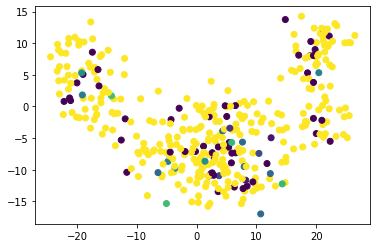

In [43]:
plt.scatter(latent.PC_1, latent.PC_2, c=np.array(psi.loc['Snx8_1']))

In [48]:
tiempo = t()
print(psix_score_2(
    np.array(psi.loc['Snx8_1']), 
    np.array(mrna.loc['Snx8_1'].fillna(0)), 
    cell_metric, 
    capture_efficiency = 0.1, 
    randomize = False,  
    min_probability = 0.01,
    seed=1230
))
print(t()-tiempo)


-0.018061733021333973
0.12092351913452148


In [27]:
tiempo = t()
print(psix_score_1(
    psi.loc['Clta_4'], 
    mrna.loc['Clta_4'], 
    cc_metric, 
    capture_efficiency = 0.1, 
    randomize = False,  
    min_probability = 0.01,
    seed=0
))
print(t()-tiempo)


NameError: name 'psix_score_1' is not defined

In [182]:
np.random.choice(range(ncells), len(ncells), replace=False)

[9, 2, 3, 6, 8, 4, 1, 7, 5, 0]

In [188]:
np.random.choice(range(10), 10, replace=False)

array([4, 7, 8, 1, 9, 6, 2, 5, 0, 3])

In [185]:
np.random.shuffle([1, 2])